# **Regression Rumble NDC 2025**

Author: Harry Mardika

## Setup & Configuration 

In [1]:
import os
import gc
import joblib
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, norm, loguniform
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, QuantileTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression

In [30]:
# -- Path File  --
TRAIN_PATH = 'data/regression-rumble-ndc-2025/train.csv'
TEST_PATH = 'data/regression-rumble-ndc-2025/test.csv'
SUBMISSION_PATH = 'data/regression-rumble-ndc-2025/sample_submission.csv'

# --- Konstanta ---
SEED = 42
TARGET = 'hydrostatic_pressure'
SEED = 42
N_SPLITS = 10

# -- Konfigurasi Dasar --
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

np.random.seed(SEED)

## Data Preparation

In [3]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [4]:
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)
df = df.sort_values(by='measurement_id')
df = df.reset_index(drop=True)

In [5]:
df.head()

,measurement_id,depth_reading_time,water_temperature_50m,salinity_50m,oxygen_saturation_50m,perceived_water_density,sediment_deposition,seafloor_pressure,plankton_density,microplankton_density,mesoplankton_density,macroplankton_density,dissolved_gas_pressure,current_velocity_near_surface,current_velocity_deep,current_direction_near_surface,current_direction_deep,current_turbulence,sediment_temperature_0_to_10cm,sediment_temperature_10_to_30cm,sediment_temperature_30_to_100cm,sediment_temperature_100_to_250cm,sediment_porosity_0_to_10cm,sediment_porosity_10_to_30cm,sediment_porosity_30_to_100cm,sediment_porosity_100_to_250cm,blue_light_penetration,downwelling_light,scattered_light,perpendicular_light_intensity,thermal_emissions,is_photic_zone,photoperiod_intensity,chlorophyll_a_concentration (mg m-3),nitrate_concentration (µmol L-1),phosphate_concentration (µmol L-1),silicate_concentration (µmol L-1),total_alkalinity (µmol kg-1),dissolved_inorganic_carbon (µmol kg-1),pH,partial_pressure_CO2 (µatm),aragonite_saturation_state,sea_surface_height_anomaly (cm),significant_wave_height (m),bottom_current_shear_stress (Pa),sound_speed_water (m s-1),acoustic_backscatter_intensity (dB),turbidity (NTU),light_attenuation_coefficient_Kd (m⁻¹),bioluminescence_intensity (photons cm-2 s-1),Brunt_Vaisala_frequency_squared (s-2),mixed_layer_depth (m),hydrostatic_pressure,total_light_exposure
0,1,2022-01-01 00:00:00,NaN,12.7,"20,7","25,7","0,1",0.9872,52.0,3.0,32.0,NaN,NaN,3.975,8.175,298.0,278.0,"16,6",296.95,NaN,298.65,298.55,"0,272",NaN,"0,269","0,323",0.0,0.0,0.0,NaN,0,0.0,0.0,3.224434,4.327586,0.245655,4.630902,2179.063110,NaN,NaN,NaN,NaN,-1.451344,0.959121,NaN,1496.157771,-61.838223,5.826377,0.716677,5.253051e+06,0.000014,55.703523,NaN,0.0
1,2,2022-01-01 01:00:00,295.35,NaN,"20,3","25,5",NaN,0.9867,NaN,NaN,NaN,NaN,"0,29",3.975,9.525,298.0,295.0,"8,3",NaN,298.45,298.65,298.55,"0,271","0,278","0,269",NaN,0.0,NaN,0.0,0,0,0.0,0.0,3.577219,NaN,0.258023,3.147517,2163.040961,2069.428976,8.138739,NaN,2.947761,3.325856,1.062183,0.017627,NaN,-65.513550,5.883116,0.773086,2.032279e+07,NaN,45.398676,1.0109,NaN
2,3,2022-01-01 02:00:00,NaN,13.9,"20,2","25,4",0,0.9858,42.0,7.0,10.0,100.0,"0,37",NaN,12.600,NaN,315.0,NaN,NaN,298.25,298.65,298.55,"0,271","0,278","0,269",NaN,0.0,0.0,0.0,0,0,0.0,0.0,2.907752,4.450997,0.278808,4.499263,NaN,NaN,NaN,NaN,NaN,NaN,1.500959,NaN,NaN,-61.667442,5.042899,0.631707,NaN,0.000011,38.188092,1.0100,NaN
3,4,2022-01-01 03:00:00,295.65,14.2,"20,1","25,1",0,0.9858,43.0,8.0,9.0,100.0,"0,38",NaN,NaN,320.0,313.0,"15,1",296.25,298.15,298.65,298.55,"0,27",NaN,"0,268","0,323",0.0,NaN,0.0,0,0,0.0,0.0,3.235939,NaN,0.213943,4.348097,2228.133421,NaN,8.169724,378.894643,2.804115,3.744792,1.744662,0.069485,1498.294603,-62.421067,5.562290,NaN,1.999648e+06,0.000068,50.566638,NaN,0.0
4,5,2022-01-01 04:00:00,295.85,14.8,"19,9","25,6",0,0.9857,NaN,13.0,NaN,100.0,"0,43",4.800,12.075,308.0,312.0,18,296.15,297.95,298.65,298.55,"0,27",NaN,NaN,"0,323",0.0,0.0,0.0,0,NaN,0.0,0.0,NaN,3.098552,0.200462,3.412068,2199.583807,2065.493823,8.267341,352.226746,NaN,5.458362,1.147936,0.021427,1503.777335,NaN,5.733180,0.655675,4.292172e+06,0.000030,45.305633,1.0098,NaN


### Check information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21888 entries, 0 to 21887
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   measurement_id                                21888 non-null  int64  
 1   depth_reading_time                            18570 non-null  object 
 2   water_temperature_50m                         10375 non-null  float64
 3   salinity_50m                                  17110 non-null  float64
 4   oxygen_saturation_50m                         17651 non-null  object 
 5   perceived_water_density                       20481 non-null  object 
 6   sediment_deposition                           14757 non-null  object 
 7   seafloor_pressure                             17455 non-null  float64
 8   plankton_density                              14552 non-null  float64
 9   microplankton_density                         15736 non-null 

### Check missing value

In [7]:
df.isnull().sum()

measurement_id                                      0
depth_reading_time                               3318
water_temperature_50m                           11513
salinity_50m                                     4778
oxygen_saturation_50m                            4237
perceived_water_density                          1407
sediment_deposition                              7131
seafloor_pressure                                4433
plankton_density                                 7336
microplankton_density                            6152
mesoplankton_density                             5530
macroplankton_density                            3837
dissolved_gas_pressure                           3736
current_velocity_near_surface                    7827
current_velocity_deep                            4118
current_direction_near_surface                   4619
current_direction_deep                           4768
current_turbulence                               6849
sediment_temperature_0_to_10

In [8]:
# 1. First, let's examine the missing value patterns
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.concat([missing_values, missing_percent], axis=1, keys=['Missing Count', 'Missing Percent'])
print("Columns with highest missing percentages:")
print(missing_df[missing_df['Missing Count'] > 0].head(20))

Columns with highest missing percentages:
                                        Missing Count  Missing Percent
total_light_exposure                            16197        73.999452
aragonite_saturation_state                      12100        55.281433
pH                                              12031        54.966192
water_temperature_50m                           11513        52.599598
dissolved_inorganic_carbon (µmol kg-1)          11292        51.589912
partial_pressure_CO2 (µatm)                     11142        50.904605
current_velocity_near_surface                    7827        35.759320
plankton_density                                 7336        33.516082
sediment_deposition                              7131        32.579496
current_turbulence                               6849        31.291118
hydrostatic_pressure                             6567        30.002741
microplankton_density                            6152        28.106725
sediment_porosity_30_to_100cm      

### Check duplicate data

In [9]:
# Check for duplicate rows in the dataframe
duplicate_rows = df_train.duplicated().sum()
print(f"Total number of duplicate rows: {duplicate_rows}")

# Check for duplicate measurement_id values
duplicate_ids = df_train['measurement_id'].duplicated().sum()
print(f"Total number of duplicate measurement IDs: {duplicate_ids}")

# If there are duplicates, examine them
if duplicate_ids > 0:
    print("\nDuplicate measurement IDs:")
    duplicate_id_values = df_train[df_train['measurement_id'].duplicated(keep=False)].sort_values('measurement_id')
    print(duplicate_id_values['measurement_id'].value_counts().head(10))

Total number of duplicate rows: 0
Total number of duplicate measurement IDs: 0


### Check data type

In [10]:
# Get all columns with object data type
object_columns = df.select_dtypes(include=['object']).columns

# Display a sample of each object column to examine their content
for column in object_columns:
    print(f"\n===== Column: {column} =====")
    print(f"Total values: {df[column].count()} non-null out of {len(df)} entries")
    print(f"Unique values: {df[column].nunique()}")
    print("Sample values:")
    print(df[column].sample(5).values)
    
    # Check if the column might contain numeric values in string format
    try:
        # Try to convert a sample to float to see if it's numeric data stored as string
        sample = df[column].dropna().sample(10).str.replace(',', '.').astype(float)
        print("This column appears to contain numeric values stored as strings (commas instead of decimal points)")
    except:
        # If conversion fails, likely not numeric data or different format
        pass


===== Column: depth_reading_time =====
Total values: 18570 non-null out of 21888 entries
Unique values: 18570
Sample values:
['2022-10-23 21:00:00' '2023-09-15 06:00:00' '2023-11-19 06:00:00'
 '2023-04-01 21:00:00' '2023-06-09 23:00:00']

===== Column: oxygen_saturation_50m =====
Total values: 17651 non-null out of 21888 entries
Unique values: 126
Sample values:
['22,1' '22,6' nan nan nan]
This column appears to contain numeric values stored as strings (commas instead of decimal points)

===== Column: perceived_water_density =====
Total values: 20481 non-null out of 21888 entries
Unique values: 205
Sample values:
['35,4' '21,5' '36,2' '28,2' '31,2']
This column appears to contain numeric values stored as strings (commas instead of decimal points)

===== Column: sediment_deposition =====
Total values: 14757 non-null out of 21888 entries
Unique values: 216
Sample values:
['0.0' '0,1' nan '1,6' nan]
This column appears to contain numeric values stored as strings (commas instead of decima

## Data Preprocessing

### Fill missing datetime

In [11]:
# 1. Pastikan Tipe Data Benar
df['depth_reading_time'] = pd.to_datetime(df['depth_reading_time'], errors='coerce')

# Cek jumlah missing value sebelum diisi
print("Jumlah missing values SEBELUM diisi:")
print(df['depth_reading_time'].isna().sum())
print("-" * 30)

# 2. Identifikasi NaN Asli
is_nan = df['depth_reading_time'].isna()

# 3. Forward Fill untuk mendapatkan 'base time'
base_time = df['depth_reading_time'].ffill()

# 4. Buat Grup NaN Berurutan (dan non-NaN)
group_id = is_nan.ne(is_nan.shift()).cumsum()

# 5. Hitung Penambah Jam untuk setiap NaN dalam grupnya
hours_to_add = df.groupby(group_id).cumcount() + 1

# 6. Buat Timedelta (penambah waktu) hanya untuk baris yang aslinya NaN
time_delta = pd.to_timedelta(hours_to_add[is_nan], unit='h')

# 7. Tambahkan Timedelta ke 'base_time' hanya untuk baris yang aslinya NaN
filled_values = base_time[is_nan] + time_delta

# 8. Update DataFrame Asli
df.loc[is_nan, 'depth_reading_time'] = filled_values

# Cek jumlah missing value setelah diisi
print("\nJumlah missing values SETELAH diisi:")
print(df['depth_reading_time'].isna().sum())
print("-" * 30)

Jumlah missing values SEBELUM diisi:
3318
------------------------------

Jumlah missing values SETELAH diisi:
0
------------------------------


In [12]:
df.head()

,measurement_id,depth_reading_time,water_temperature_50m,salinity_50m,oxygen_saturation_50m,perceived_water_density,sediment_deposition,seafloor_pressure,plankton_density,microplankton_density,mesoplankton_density,macroplankton_density,dissolved_gas_pressure,current_velocity_near_surface,current_velocity_deep,current_direction_near_surface,current_direction_deep,current_turbulence,sediment_temperature_0_to_10cm,sediment_temperature_10_to_30cm,sediment_temperature_30_to_100cm,sediment_temperature_100_to_250cm,sediment_porosity_0_to_10cm,sediment_porosity_10_to_30cm,sediment_porosity_30_to_100cm,sediment_porosity_100_to_250cm,blue_light_penetration,downwelling_light,scattered_light,perpendicular_light_intensity,thermal_emissions,is_photic_zone,photoperiod_intensity,chlorophyll_a_concentration (mg m-3),nitrate_concentration (µmol L-1),phosphate_concentration (µmol L-1),silicate_concentration (µmol L-1),total_alkalinity (µmol kg-1),dissolved_inorganic_carbon (µmol kg-1),pH,partial_pressure_CO2 (µatm),aragonite_saturation_state,sea_surface_height_anomaly (cm),significant_wave_height (m),bottom_current_shear_stress (Pa),sound_speed_water (m s-1),acoustic_backscatter_intensity (dB),turbidity (NTU),light_attenuation_coefficient_Kd (m⁻¹),bioluminescence_intensity (photons cm-2 s-1),Brunt_Vaisala_frequency_squared (s-2),mixed_layer_depth (m),hydrostatic_pressure,total_light_exposure
0,1,2022-01-01 00:00:00,NaN,12.7,"20,7","25,7","0,1",0.9872,52.0,3.0,32.0,NaN,NaN,3.975,8.175,298.0,278.0,"16,6",296.95,NaN,298.65,298.55,"0,272",NaN,"0,269","0,323",0.0,0.0,0.0,NaN,0,0.0,0.0,3.224434,4.327586,0.245655,4.630902,2179.063110,NaN,NaN,NaN,NaN,-1.451344,0.959121,NaN,1496.157771,-61.838223,5.826377,0.716677,5.253051e+06,0.000014,55.703523,NaN,0.0
1,2,2022-01-01 01:00:00,295.35,NaN,"20,3","25,5",NaN,0.9867,NaN,NaN,NaN,NaN,"0,29",3.975,9.525,298.0,295.0,"8,3",NaN,298.45,298.65,298.55,"0,271","0,278","0,269",NaN,0.0,NaN,0.0,0,0,0.0,0.0,3.577219,NaN,0.258023,3.147517,2163.040961,2069.428976,8.138739,NaN,2.947761,3.325856,1.062183,0.017627,NaN,-65.513550,5.883116,0.773086,2.032279e+07,NaN,45.398676,1.0109,NaN
2,3,2022-01-01 02:00:00,NaN,13.9,"20,2","25,4",0,0.9858,42.0,7.0,10.0,100.0,"0,37",NaN,12.600,NaN,315.0,NaN,NaN,298.25,298.65,298.55,"0,271","0,278","0,269",NaN,0.0,0.0,0.0,0,0,0.0,0.0,2.907752,4.450997,0.278808,4.499263,NaN,NaN,NaN,NaN,NaN,NaN,1.500959,NaN,NaN,-61.667442,5.042899,0.631707,NaN,0.000011,38.188092,1.0100,NaN
3,4,2022-01-01 03:00:00,295.65,14.2,"20,1","25,1",0,0.9858,43.0,8.0,9.0,100.0,"0,38",NaN,NaN,320.0,313.0,"15,1",296.25,298.15,298.65,298.55,"0,27",NaN,"0,268","0,323",0.0,NaN,0.0,0,0,0.0,0.0,3.235939,NaN,0.213943,4.348097,2228.133421,NaN,8.169724,378.894643,2.804115,3.744792,1.744662,0.069485,1498.294603,-62.421067,5.562290,NaN,1.999648e+06,0.000068,50.566638,NaN,0.0
4,5,2022-01-01 04:00:00,295.85,14.8,"19,9","25,6",0,0.9857,NaN,13.0,NaN,100.0,"0,43",4.800,12.075,308.0,312.0,18,296.15,297.95,298.65,298.55,"0,27",NaN,NaN,"0,323",0.0,0.0,0.0,0,NaN,0.0,0.0,NaN,3.098552,0.200462,3.412068,2199.583807,2065.493823,8.267341,352.226746,NaN,5.458362,1.147936,0.021427,1503.777335,NaN,5.733180,0.655675,4.292172e+06,0.000030,45.305633,1.0098,NaN


In [13]:
# Check distribution of dates
print("\nDate range for depth_reading_time in training data:")
print(f"Earliest date: {df['depth_reading_time'].min()}")
print(f"Latest date: {df['depth_reading_time'].max()}")


Date range for depth_reading_time in training data:
Earliest date: 2022-01-01 00:00:00
Latest date: 2024-06-30 23:00:00


### Add datetime features

In [14]:
# Extract additional datetime features that might be useful for modeling
df['year'] = df['depth_reading_time'].dt.year
df['month'] = df['depth_reading_time'].dt.month
df['day'] = df['depth_reading_time'].dt.day
df['hour'] = df['depth_reading_time'].dt.hour
df['dayofweek'] = df['depth_reading_time'].dt.dayofweek

print("\nNew datetime features added to the dataframes")


New datetime features added to the dataframes


In [15]:
df[['year', 'month', 'day', 'hour', 'dayofweek']].head()

,year,month,day,hour,dayofweek
0,2022,1,1,0,5
1,2022,1,1,1,5
2,2022,1,1,2,5
3,2022,1,1,3,5
4,2022,1,1,4,5


### Convert type of data

In [16]:
# Process all object columns to convert to float where possible
for column in object_columns:
    if column == 'depth_reading_time' or column == 'measurement_id':
        # Skip timestamp column
        continue
    
    try:
        # Replace comma with dot for decimal point
        df[column] = df[column].str.replace(',', '.').astype(float)
        print(f"Converted {column} to float")
        
    except Exception as e:
        print(f"Could not convert {column}: {e}")

# Check the result for thermal_emissions specifically
print("\nThermal emissions data type:", df['thermal_emissions'].dtype)

Converted oxygen_saturation_50m to float
Converted perceived_water_density to float
Converted sediment_deposition to float
Converted dissolved_gas_pressure to float
Converted current_turbulence to float
Converted sediment_porosity_0_to_10cm to float
Converted sediment_porosity_10_to_30cm to float
Converted sediment_porosity_30_to_100cm to float
Converted sediment_porosity_100_to_250cm to float
Converted perpendicular_light_intensity to float
Converted thermal_emissions to float

Thermal emissions data type: float64


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21888 entries, 0 to 21887
Data columns (total 59 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   measurement_id                                21888 non-null  int64         
 1   depth_reading_time                            21888 non-null  datetime64[ns]
 2   water_temperature_50m                         10375 non-null  float64       
 3   salinity_50m                                  17110 non-null  float64       
 4   oxygen_saturation_50m                         17651 non-null  float64       
 5   perceived_water_density                       20481 non-null  float64       
 6   sediment_deposition                           14757 non-null  float64       
 7   seafloor_pressure                             17455 non-null  float64       
 8   plankton_density                              14552 non-null  floa

### Implement iterative imputation

#### All Column

In [18]:
# Select relevant features for imputation (excluding ID and timestamp)
features_for_imputation = df.columns.drop(['measurement_id', 'depth_reading_time']).tolist()
X = df[features_for_imputation]

In [19]:
# 1. Fungsi untuk mendeteksi outlier pada data
def detect_and_handle_outliers(X, threshold=3):
    """
    Mendeteksi outlier menggunakan metode Z-score dan menggantinya dengan nilai batas
    threshold: jumlah standar deviasi untuk mengidentifikasi outlier
    """
    X_clean = X.copy()
    for col in X.columns:
        if X[col].dtype.kind in 'bifc':  # Hanya kolom numerik
            z_scores = np.abs((X[col] - X[col].mean()) / X[col].std())
            outliers = z_scores > threshold
            
            # Ganti outlier dengan batas atas atau bawah (capping)
            upper_bound = X[col].mean() + threshold * X[col].std()
            lower_bound = X[col].mean() - threshold * X[col].std()
            
            X_clean.loc[outliers & (X[col] > upper_bound), col] = upper_bound
            X_clean.loc[outliers & (X[col] < lower_bound), col] = lower_bound
            
            print(f"Kolom {col}: {outliers.sum()} outlier ditemukan dan ditangani")
    
    return X_clean

# 2. Optimasi hyperparameter untuk XGBoost
def optimize_xgboost_params(X, cv=5):
    """
    Melakukan pencarian acak untuk menemukan hyperparameter terbaik
    cv: jumlah fold untuk cross-validation (default 5)
    """
    # Pisahkan sebagian kecil dataset untuk optimasi
    sample_size = min(5000, X.shape[0])  # Batasi ukuran sampel untuk kecepatan
    sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sample = X.iloc[sample_indices]
    
    # Buat matriks dummy untuk target (untuk regresi kita hanya butuh nilai acak)
    y_dummy = np.random.randn(sample_size)
    
    # Definisikan ruang parameter
    param_dist = {
        'n_estimators': randint(100, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'min_child_weight': randint(1, 10),
        'gamma': uniform(0, 0.5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1)
    }
    
    # Buat model dasar
    xgb_base = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',
        random_state=SEED,
        n_jobs=-1
    )
    
    # Buat cross-validator
    # Untuk dataset besar, stratifikasi bisa menjadi masalah
    # jadi kita gunakan KFold sederhana dengan shuffling
    kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)
    
    # Buat pencari parameter
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_dist,
        n_iter=30,
        scoring='neg_mean_squared_error',
        cv=kf,
        verbose=1,
        random_state=SEED,
        n_jobs=-1
    )
    
    # Fill NaN values temporarily for optimization
    X_sample_filled = X_sample.fillna(X_sample.median())
    
    # Fit model
    random_search.fit(X_sample_filled, y_dummy)
    
    print("Parameter terbaik:", random_search.best_params_)
    return random_search.best_params_

# 3. Proses untuk persiapan data 
def prepare_data(X):
    """
    Mempersiapkan data sebelum imputasi
    """
    # Hitung korelasi antar fitur
    correlation_matrix = X.corr(method='pearson', min_periods=100)
    
    # Identifikasi fitur dengan korelasi tinggi (multi-collinearity)
    threshold = 0.85
    high_corr_pairs = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                high_corr_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print(f"Ditemukan {len(high_corr_pairs)} pasangan fitur dengan korelasi tinggi (>{threshold}):")
        for col1, col2, corr in high_corr_pairs:
            print(f"  {col1} dan {col2}: {corr:.4f}")
    
    # Identifikasi fitur dengan terlalu banyak nilai hilang
    missing_ratio = X.isnull().mean()
    too_many_missing = missing_ratio[missing_ratio > 0.8].index.tolist()
    
    if too_many_missing:
        print(f"Fitur dengan >80% nilai hilang: {too_many_missing}")
        print("Pertimbangkan untuk menghapus fitur-fitur ini.")
    
    return X

# 4. Fungsi utama untuk melakukan imputasi XGBoost yang dioptimasi
def optimized_xgboost_imputation(X, max_iter=15, optimize=True):
    """
    Melakukan imputasi data dengan XGBoost yang telah dioptimasi
    X: DataFrame dengan nilai yang hilang
    max_iter: jumlah iterasi maksimum untuk IterativeImputer
    optimize: apakah akan melakukan optimasi hyperparameter
    """
    print(f"\nMemulai proses imputasi untuk data dengan bentuk {X.shape}...")
    
    # Persiapan data
    X = prepare_data(X)
    
    # Deteksi dan tangani outlier
    X_no_outliers = detect_and_handle_outliers(X)
    
    # Optimasi hyperparameter jika diminta
    if optimize:
        print("\nMemulai optimasi hyperparameter XGBoost...")
        best_params = optimize_xgboost_params(X_no_outliers)
        xgb_estimator = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            min_child_weight=best_params['min_child_weight'],
            gamma=best_params['gamma'],
            reg_alpha=best_params['reg_alpha'],
            reg_lambda=best_params['reg_lambda'],
            random_state=SEED,
            n_jobs=-1,
            tree_method='hist',
            importance_type='gain'  # Untuk feature importance
        )
    else:
        # Gunakan parameter yang sudah dioptimasi sebelumnya untuk dataset sejenis
        xgb_estimator = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=0.2,
            random_state=SEED,
            n_jobs=-1,
            tree_method='hist',
            importance_type='gain'
        )
    
    # Buat IterativeImputer dengan estimator XGBoost
    iterative_imputer_xgb = IterativeImputer(
        estimator=xgb_estimator,
        max_iter=max_iter,
        initial_strategy='median',
        imputation_order='ascending', 
        random_state=SEED,
        sample_posterior=False,
        verbose=2,
        skip_complete=True,
        add_indicator=True
    )
    
    # Simpan urutan kolom asli
    original_columns = X.columns.tolist()
    
    print("\nMemulai imputasi iteratif dengan XGBoost yang dioptimasi...")
    
    # Lakukan imputasi
    X_imputed_array = iterative_imputer_xgb.fit_transform(X_no_outliers)
    
    # Konversi hasil kembali ke DataFrame dengan penanganan indikator yang lebih aman
    n_features_original = X.shape[1]
    
    # Cara yang lebih aman untuk menangani kolom indikator
    if hasattr(iterative_imputer_xgb, 'indicator_') and iterative_imputer_xgb.add_indicator:
        # Hitung berapa banyak kolom indikator yang ditambahkan
        n_indicators = sum(iterative_imputer_xgb.indicator_.features_)
        # Buat daftar nama kolom baru
        missing_indicators = [f"missing_indicator_{i}" for i in range(n_indicators)]
        all_columns = original_columns + missing_indicators
    else:
        all_columns = original_columns
    
    # Pastikan jumlah kolom sesuai dengan output
    final_columns = all_columns[:X_imputed_array.shape[1]]
    
    X_imputed_xgb = pd.DataFrame(
        X_imputed_array,
        columns=final_columns,
        index=X.index
    )
    
    # Verifikasi hasil imputasi
    print("\nImputasi data dengan XGBoost selesai.")
    print(f"Bentuk data setelah imputasi: {X_imputed_xgb.shape}")
    print(f"Jumlah nilai hilang setelah imputasi: {X_imputed_xgb.isnull().sum().sum()}")
    
    # Analisis feature importance dari estimator terakhir secara aman
    if hasattr(iterative_imputer_xgb, 'estimators_') and iterative_imputer_xgb.estimators_:
        try:
            # Ambil estimator dari iterasi terakhir untuk fitur pertama
            last_estimator = iterative_imputer_xgb.estimators_[-1][0]
            
            if hasattr(last_estimator, 'feature_importances_'):
                # Dapatkan feature importance
                importances = last_estimator.feature_importances_
                # Pastikan panjang importances sesuai dengan jumlah kolom
                if len(importances) <= len(original_columns):
                    indices = np.argsort(importances)[::-1]
                    
                    # Plot top N feature importance
                    N = min(20, len(importances))
                    # Pastikan indeks berada dalam range yang valid
                    valid_indices = [i for i in indices[:N] if i < len(original_columns)]
                    valid_importances = importances[valid_indices]
                    feature_names = [original_columns[i] for i in valid_indices]
                    
                    plt.figure(figsize=(12, 8))
                    plt.title('Top Feature Importances dalam Proses Imputasi')
                    plt.barh(range(len(valid_indices)), valid_importances, align='center')
                    plt.yticks(range(len(valid_indices)), feature_names)
                    plt.xlabel('Relative Importance')
                    plt.tight_layout()
                    plt.show()
        except Exception as e:
            print(f"Gagal menganalisis feature importance: {e}")

    return X_imputed_xgb

In [20]:
X_imputed = optimized_xgboost_imputation(X, max_iter=15, optimize=True)
X_imputed.to_csv('data/submission/omnipotech_1.csv', index=False)


Memulai proses imputasi untuk data dengan bentuk (21888, 57)...
Ditemukan 27 pasangan fitur dengan korelasi tinggi (>0.85):
  perceived_water_density dan water_temperature_50m: 0.9470
  dissolved_gas_pressure dan salinity_50m: 0.9836
  current_velocity_deep dan current_velocity_near_surface: 0.9147
  sediment_temperature_0_to_10cm dan water_temperature_50m: 0.9026
  sediment_porosity_10_to_30cm dan sediment_porosity_0_to_10cm: 0.9341
  downwelling_light dan blue_light_penetration: 0.9579
  perpendicular_light_intensity dan blue_light_penetration: 0.9006
  perpendicular_light_intensity dan downwelling_light: 0.9457
  thermal_emissions dan blue_light_penetration: 0.9244
  thermal_emissions dan scattered_light: 0.9277
  photoperiod_intensity dan blue_light_penetration: 0.8508
  photoperiod_intensity dan perpendicular_light_intensity: 0.9031
  phosphate_concentration (µmol L-1) dan nitrate_concentration (µmol L-1): 0.9467
  dissolved_inorganic_carbon (µmol kg-1) dan water_temperature_50m:

In [21]:
# Tampilkan jumlah missing values sebelum dan sesudah
print("\nJumlah missing values sebelum imputasi:")
print(X.isna().sum().sum())

print("\nJumlah missing values setelah imputasi:")
print(X_imputed.isna().sum().sum())


Jumlah missing values sebelum imputasi:
251283

Jumlah missing values setelah imputasi:
0


In [24]:
def process_imputation_results(df, X_imputed):
    """
    Proses hasil imputasi dan kembalikan dataframe siap pakai
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame asli
    X_imputed : DataFrame
        DataFrame hasil imputasi
        
    Returns:
    --------
    DataFrame
        DataFrame yang sudah terisi nilai kosongnya
    """
    # 1. Identifikasi kolom indikator dan kolom asli
    indicator_columns = [col for col in X_imputed.columns if col.startswith('missing_indicator_')]
    original_columns = [col for col in X_imputed.columns if not col.startswith('missing_indicator_')]
    
    print(f"\nKolom asli: {len(original_columns)}")
    print(f"Kolom indikator: {len(indicator_columns)}")
    
    # 2. Ekstrak hanya kolom asli
    X_imputed_original = X_imputed[original_columns]
    
    # 3. Terapkan ke dataframe asli
    df_imputed = df.copy()
    
    print("\nMengisi nilai null di dataframe...")
    print(f"Jumlah nilai kosong sebelum: {df_imputed.isna().sum().sum()}")
    
    # Isi hanya kolom yang ada di df asli
    for column in original_columns:
        if column in df_imputed.columns:
            missing_mask = df_imputed[column].isna()
            if missing_mask.any():
                df_imputed.loc[missing_mask, column] = X_imputed_original.loc[missing_mask, column]
                print(f"Mengisi {missing_mask.sum()} nilai kosong di kolom '{column}'")
    
    print(f"Jumlah nilai kosong setelah: {df_imputed.isna().sum().sum()}")
    
    return df_imputed

In [26]:
df_final = process_imputation_results(df, X_imputed)
df_final.to_csv('data/submission/omnipotech_1.csv', index=False)


Kolom asli: 57
Kolom indikator: 52

Mengisi nilai null di dataframe...
Jumlah nilai kosong sebelum: 251283
Mengisi 11513 nilai kosong di kolom 'water_temperature_50m'
Mengisi 4778 nilai kosong di kolom 'salinity_50m'
Mengisi 4237 nilai kosong di kolom 'oxygen_saturation_50m'
Mengisi 1407 nilai kosong di kolom 'perceived_water_density'
Mengisi 7131 nilai kosong di kolom 'sediment_deposition'
Mengisi 4433 nilai kosong di kolom 'seafloor_pressure'
Mengisi 7336 nilai kosong di kolom 'plankton_density'
Mengisi 6152 nilai kosong di kolom 'microplankton_density'
Mengisi 5530 nilai kosong di kolom 'mesoplankton_density'
Mengisi 3837 nilai kosong di kolom 'macroplankton_density'
Mengisi 3736 nilai kosong di kolom 'dissolved_gas_pressure'
Mengisi 7827 nilai kosong di kolom 'current_velocity_near_surface'
Mengisi 4118 nilai kosong di kolom 'current_velocity_deep'
Mengisi 4619 nilai kosong di kolom 'current_direction_near_surface'
Mengisi 4768 nilai kosong di kolom 'current_direction_deep'
Mengis

In [27]:
# Verifikasi hasil imputasi
print("\n===== VERIFIKASI HASIL IMPUTASI =====")
print("Jumlah nilai yang hilang sebelum imputasi:", df.isna().sum().sum())
print("Jumlah nilai yang hilang setelah imputasi:", df_imputed.isna().sum().sum())


===== VERIFIKASI HASIL IMPUTASI =====
Jumlah nilai yang hilang sebelum imputasi: 251283
Jumlah nilai yang hilang setelah imputasi: 0


In [28]:
# 5. Periksa distribusi statistik sebelum dan sesudah imputasi
print("\n===== STATISTIK SEBELUM DAN SESUDAH IMPUTASI =====")
# Pilih beberapa kolom dengan missing values terbanyak untuk ditampilkan
missing_counts = df.isna().sum()
top_missing_cols = missing_counts[missing_counts > 0].sort_values(ascending=False).head(5).index.tolist()

if top_missing_cols:
    for col in top_missing_cols:
        print(f"\nStatistik untuk kolom '{col}':")
        print("SEBELUM:")
        print(f"- Mean: {df[col].mean():.4f}")
        print(f"- Std: {df[col].std():.4f}")
        print(f"- Min: {df[col].min():.4f}")
        print(f"- Max: {df[col].max():.4f}")
        
        print("SESUDAH:")
        print(f"- Mean: {df_imputed[col].mean():.4f}")
        print(f"- Std: {df_imputed[col].std():.4f}")
        print(f"- Min: {df_imputed[col].min():.4f}")
        print(f"- Max: {df_imputed[col].max():.4f}")


===== STATISTIK SEBELUM DAN SESUDAH IMPUTASI =====

Statistik untuk kolom 'total_light_exposure':
SEBELUM:
- Mean: 203.1866
- Std: 279.0818
- Min: 0.0000
- Max: 1039.0000
SESUDAH:
- Mean: 200.3887
- Std: 245.8150
- Min: 0.0000
- Max: 1039.0000

Statistik untuk kolom 'aragonite_saturation_state':
SEBELUM:
- Mean: 2.6976
- Std: 0.2402
- Min: 1.7393
- Max: 3.4472
SESUDAH:
- Mean: 2.7022
- Std: 0.1789
- Min: 1.7393
- Max: 3.4472

Statistik untuk kolom 'pH':
SEBELUM:
- Mean: 8.0987
- Std: 0.1095
- Min: 7.7000
- Max: 8.3000
SESUDAH:
- Mean: 8.0998
- Std: 0.0834
- Min: 7.7000
- Max: 8.3000

Statistik untuk kolom 'water_temperature_50m':
SEBELUM:
- Mean: 297.9953
- Std: 2.4616
- Min: 290.3500
- Max: 307.6500
SESUDAH:
- Mean: 297.9861
- Std: 2.2340
- Min: 290.3500
- Max: 307.6500

Statistik untuk kolom 'dissolved_inorganic_carbon (µmol kg-1)':
SEBELUM:
- Mean: 2049.8755
- Std: 33.6046
- Min: 1915.6340
- Max: 2163.9688
SESUDAH:
- Mean: 2050.2460
- Std: 28.4780
- Min: 1915.6340
- Max: 2163.9688



Visualisasi distribusi data sebelum dan sesudah imputasi telah dibuat.


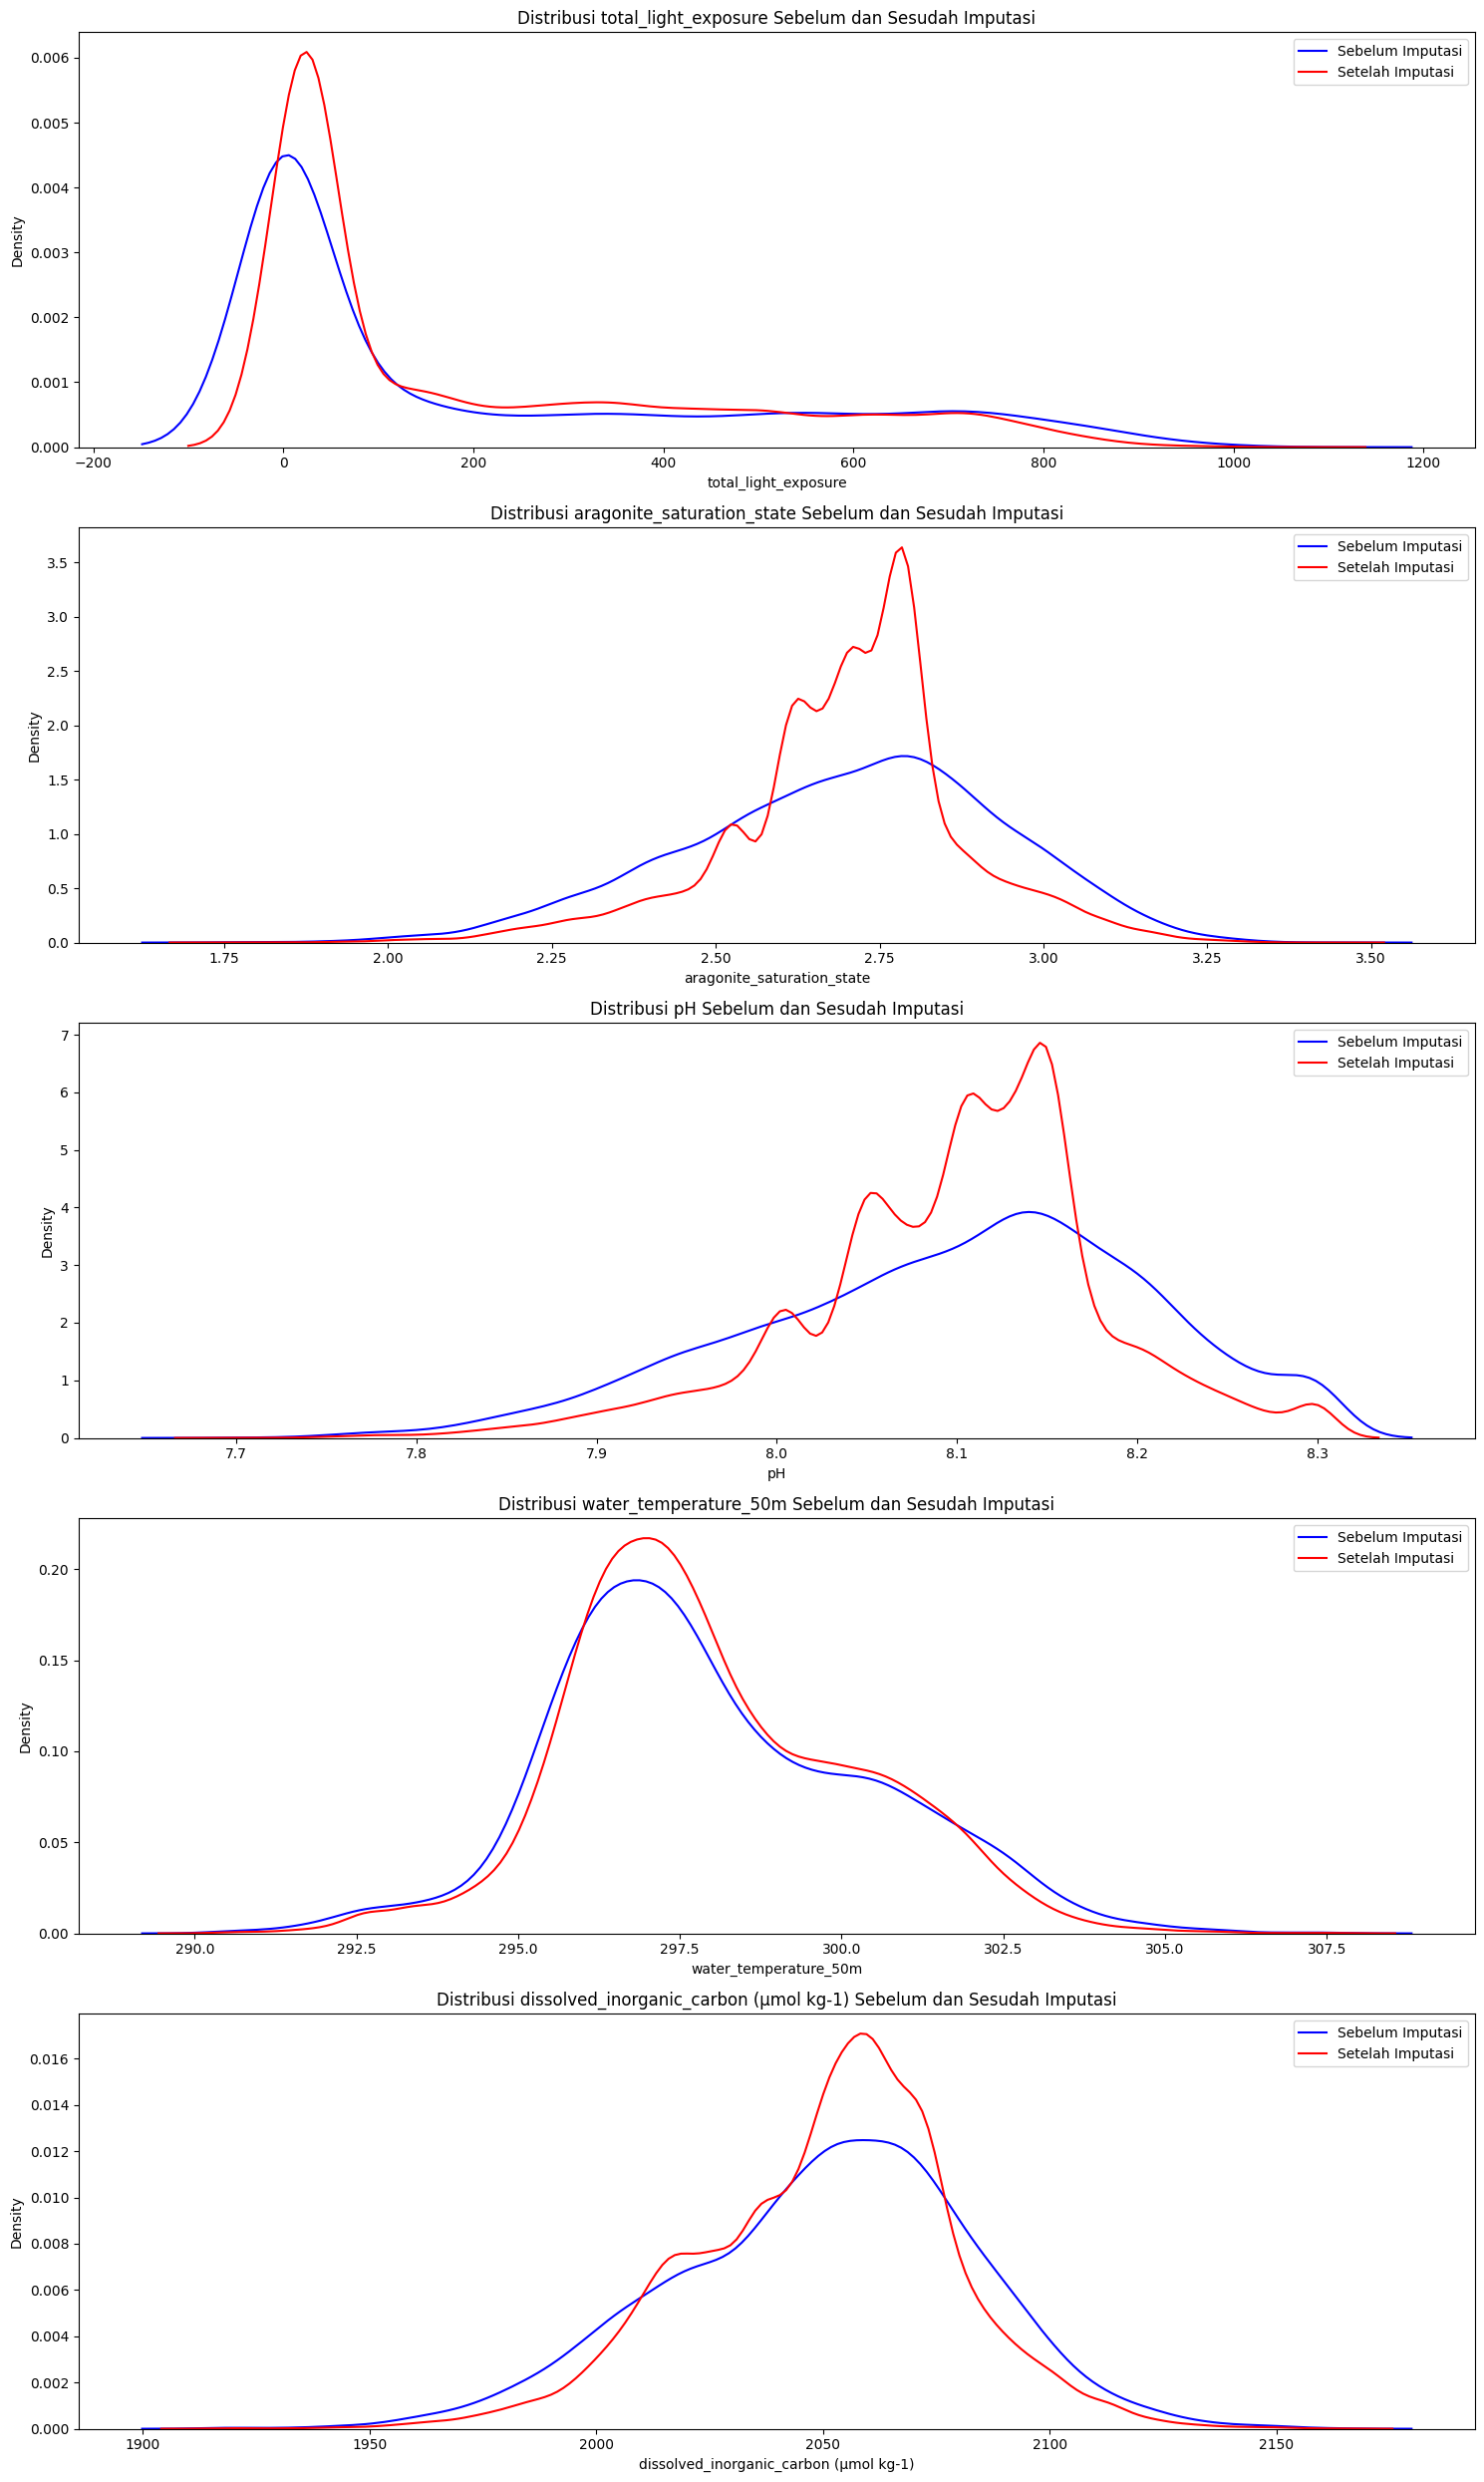

In [29]:
# 7. Visualisasi Distribusi Data Sebelum dan Sesudah Imputasi
plt.figure(figsize=(15, 5*len(top_missing_cols)))

for i, col in enumerate(top_missing_cols):
    plt.subplot(len(top_missing_cols), 1, i+1)
    
    # Tampilkan distribusi sebelum dan sesudah imputasi
    sns.kdeplot(df[col].dropna(), label='Sebelum Imputasi', color='blue')
    sns.kdeplot(df_imputed[col], label='Setelah Imputasi', color='red')
    
    plt.title(f'Distribusi {col} Sebelum dan Sesudah Imputasi')
    plt.legend()

plt.tight_layout()
print("\nVisualisasi distribusi data sebelum dan sesudah imputasi telah dibuat.")

In [32]:
df_submission = pd.read_csv(SUBMISSION_PATH)

df_final_map = df_final[['measurement_id', 'hydrostatic_pressure']].copy()

# 3. Atur 'measurement_id' sebagai indeks untuk kedua DataFrame
df_submission_indexed = df_submission.set_index('measurement_id')
df_final_map_indexed = df_final_map.set_index('measurement_id')

# 4. Perbarui kolom 'hydrostatic_pressure' di df_submission_indexed
df_submission_indexed['hydrostatic_pressure'] = df_final_map_indexed['hydrostatic_pressure']

# 5. Kembalikan 'measurement_id' menjadi kolom biasa
df_submission_updated = df_submission_indexed.reset_index()

print("\nFormat df_submission (setelah update):")
print(df_submission_updated.head())
print(f"Jumlah baris di df_submission_updated: {len(df_submission_updated)}")

nan_count = df_submission_updated['hydrostatic_pressure'].isnull().sum()
if nan_count > 0:
    print(f"\nPeringatan: Terdapat {nan_count} nilai NaN di kolom 'hydrostatic_pressure'.")
    print("Ini mungkin terjadi jika beberapa 'measurement_id' di file submission tidak ditemukan di df_final.")
else:
    print("\nSemua nilai 'hydrostatic_pressure' berhasil diperbarui.")


Format df_submission (setelah update):
   measurement_id  hydrostatic_pressure
0            7102              1.010952
1           14935              1.010952
2           16495              1.010952
3           10942              1.010952
4           12600              1.010952
Jumlah baris di df_submission_updated: 6567

Semua nilai 'hydrostatic_pressure' berhasil diperbarui.


In [34]:
df_submission_updated.to_csv('data/submission/submission_1.csv', index=False)